# Chronos - Basic Usage

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
divvy_data = pd.read_csv('data/divvy_daily_rides.csv')
divvy_data['ds'] = pd.to_datetime(divvy_data['ds'])
print(divvy_data.head())

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(divvy_data['ds'], divvy_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Trips", size=16)
plt.title(f"Trip Number Taken from Chicago's Divvy Bike Sharing Program", size=20)
plt.show()

In [ ]:
from chronos import Chronos
import chronos_plotting

In [ ]:
my_chronos = Chronos(seasonality_mode="mul", distribution="Gamma")
my_chronos.fit(divvy_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, period=365)

In [ ]:
chronos_plotting.plot_components(predictions, my_chronos);

## Advanced Use

In [ ]:
my_chronos = Chronos(max_iter=2000, 
                     learning_rate=0.01, 
                     changepoint_prior_scale=1.0,    # higher changepoint prior allows for sharper changes in trend
                                                     # but also increase future uncertainty
                     distribution="Gamma",
                     seasonality_mode="mul")
my_chronos.fit(divvy_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, period=365)

In [ ]:
chronos_plotting.plot_components(predictions, my_chronos);

## Using t-distribution to Account for Outliers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
my_ts_data = pd.read_csv('data/Peyton Manning.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.show()

In [ ]:
from chronos import Chronos
import chronos_plotting

In [ ]:
# First, use default parameters, which assumes a normal distribution.
my_chronos = Chronos()
my_chronos.fit(my_ts_data)

In [ ]:
# By default, seasonality is additive, so the seasonality plots will show the added quantities
predictions = my_chronos.predict(sample_number=1000, period=365, frequency='D')
chronos_plotting.plot_components(predictions, my_chronos);

In [ ]:
# Now let's try the same, but use a Student t-distribution
my_chronos = Chronos(distribution="StudentT")
my_chronos.fit(my_ts_data)

**We can see we're able to obtain a slightly better MAE by allowing for a t-distribution which is more resilient to outliers because of its optional fat tails**

In [ ]:
predictions = my_chronos.predict(sample_number=1000, period=365, frequency='D')
chronos_plotting.plot_components(predictions, my_chronos);

## AAPL stocks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos
import chronos_plotting

In [2]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.dropna(inplace=True)
my_ts_data['Date'] = pd.to_datetime(my_ts_data['Date'])
my_ts_data.head()

,Date,Adj Close
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


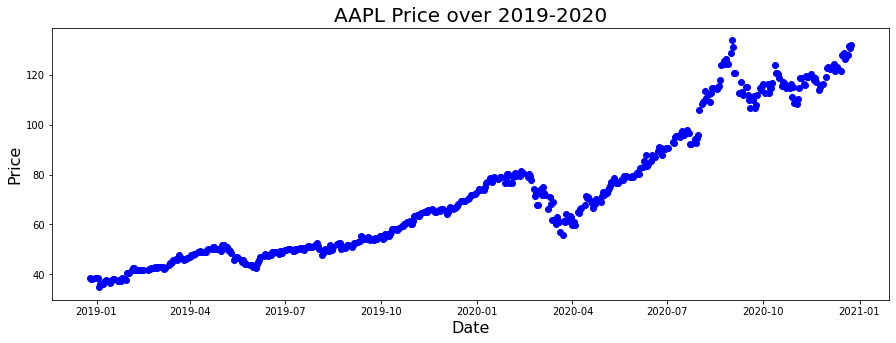

In [3]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['Date'], my_ts_data['Adj Close'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [20]:
my_chronos = Chronos(max_iter=2000, 
                     learning_rate=0.1, 
                     seasonality_mode="mul",
                     changepoint_prior_scale=5000.0,
                     distribution="Gamma", 
                     weekly_seasonality_order=0,
                     month_seasonality_order=0,
                     year_seasonality_order=0  # Turn off yearly seasonality
                    )
my_chronos.fit(my_ts_data, time_col="Date", target_col="Adj Close")

No weekends found in training data, will only consider Monday - Friday
Employing Stochastic Variational Inference
100.0% - ELBO loss: -0.9118 | Mean Absolute Error: 7.1611                                           


**Notice since stock data does not contain any readings for Saturday and Sunday, they are removed from the seasonality computation**

In [21]:
future_df = my_chronos.make_future_dataframe(period=31*3, frequency='B')    # Can also produce a future dataframe
                                                                            # and use that for predictions
predictions = my_chronos.predict(future_df, sample_number=1000)

/anaconda3/envs/chronos_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


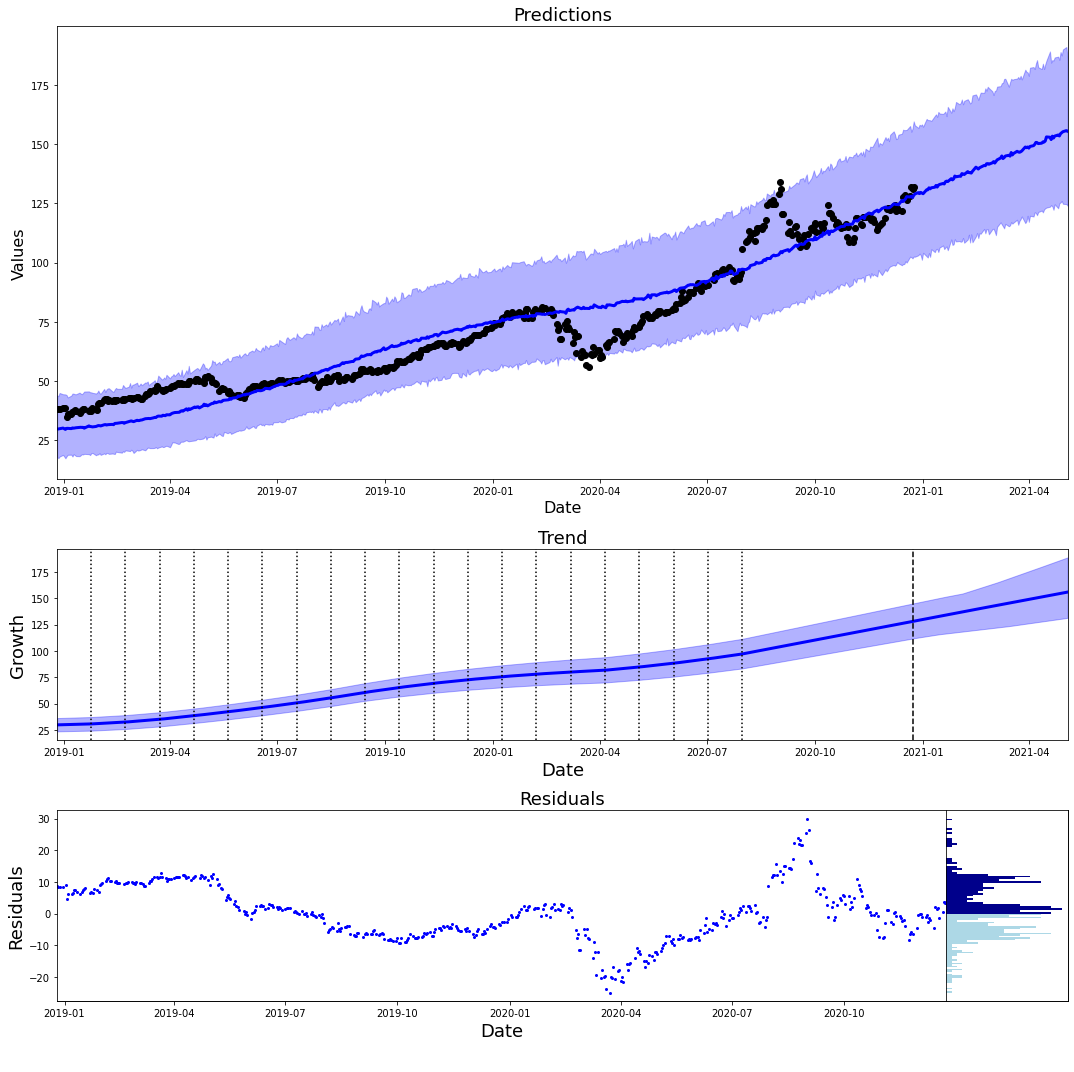

In [22]:
chronos_plotting.plot_components(predictions, my_chronos);

Notice how the monthly seasonality is hinting at a trend where stocks are at a discounted price towards the end of the month, and at a monthly high near the 15th.

In [23]:
my_chronos.changepoints_values

Parameter containing:
tensor([ 0.1634,  0.1627,  0.1493,  0.0573,  0.0574,  0.0576,  0.0773,  0.0953,
        -0.1217, -0.1216, -0.1140, -0.0920, -0.0814, -0.0807, -0.0602,  0.2526,
         0.1003,  0.1066,  0.0982,  0.2898], requires_grad=True)